In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape)

(60000, 28, 28)


## Hyperparameters

In [2]:

N = x_train.shape[0]
Batch = None
Height = 28
Width = 28
Xdim = Height * Width
Hdim = 500
Zdim = 2
lr = 1e-4

## Encoder-q(z|x) (VAE), Generator (GAN)

In [3]:
def encoder(x, reuse=False):
    with tf.variable_scope('encoder', reuse=reuse):
        h = tf.layers.dense(x, Hdim, activation=tf.nn.relu)
        h = tf.layers.dense(h, Hdim, activation=tf.nn.relu)
        z_mean = tf.layers.dense(h, Zdim)
        z_logstd = tf.layers.dense(h, Zdim)
        
    return z_mean, z_logstd



## Discriminator (GAN)

In [4]:
def discriminator(z, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        h = tf.layers.dense(z, Hdim, activation=tf.nn.relu)
        h = tf.layers.dense(h, Hdim, activation=tf.nn.relu)
        logits = tf.layers.dense(h, 1)
        
    return tf.nn.sigmoid(logits), logits
    

## Decoder-p(x|z)

In [5]:
def decoder(z, reuse=False):
    with tf.variable_scope('decoder', reuse=reuse):
        h = tf.layers.dense(z, Hdim, activation=tf.nn.relu)
        h = tf.layers.dense(h, Hdim, activation=tf.nn.relu)
        x_logits = tf.layers.dense(h, Xdim)
        
    return x_logits


## Draw Graph

In [6]:
tf.reset_default_graph()

x = tf.placeholder(dtype=tf.float32, shape=[Batch, Height * Width])

# encoder
z_mean, z_logstd = encoder(x)

# decoder
x_logits = decoder(z_mean)
x_probs = tf.nn.sigmoid(x_logits)

# reconstruction loss
marginal_likelihood = tf.reduce_sum(x * tf.log(x_probs) + (1 - x) * tf.log(1 - x_probs), 1)
marginal_likelihood = tf.reduce_mean(marginal_likelihood)

recon_loss = -marginal_likelihood

# GAN loss
eps = 1e-7
D_real, D_real_logits = discriminator(tf.random.normal(tf.shape(z_mean)))
D_fake, D_fake_logits = discriminator(z_mean, reuse=True)
D_loss = -tf.reduce_mean(tf.log(D_real + eps) + tf.log(1 - D_fake + eps))
G_loss = -tf.reduce_mean(tf.log(D_fake + eps))

# optimization
t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if "discriminator" in var.name]
g_vars = [var for var in t_vars if "encoder" in var.name]
ae_vars = [var for var in t_vars if "encoder" or "decoder" in var.name]

recon_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(recon_loss, var_list=ae_vars)
D_step = tf.train.AdamOptimizer(learning_rate=lr/5).minimize(D_loss, var_list=d_vars)
G_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(G_loss, var_list=g_vars)

# sampling
z_inputs = tf.placeholder(dtype=tf.float32, shape=[Batch, Zdim])
x_samples = decoder(z_inputs, reuse=True)

# session create
sess = tf.Session()
sess.run(tf.global_variables_initializer())

print('graph created')


graph created


In [7]:
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

## Training Loop

Z-space embedding


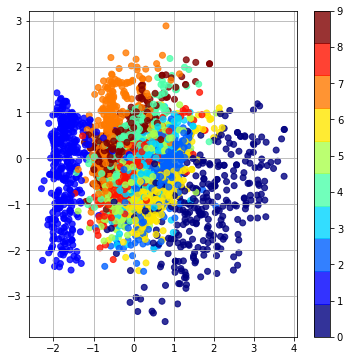

Samples


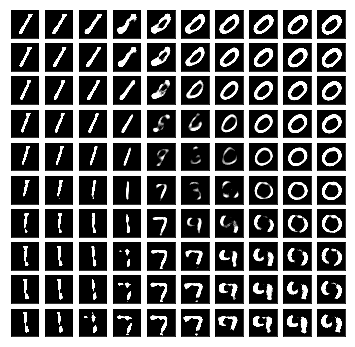

loss :  156.04758
d loss : 1.3772732 g loss :  0.64768517
loss :  151.361
d loss : 1.3730826 g loss :  0.65081054
loss :  152.298
d loss : 1.3793861 g loss :  0.64850146
loss :  151.2313
d loss : 1.3785771 g loss :  0.65190417
loss :  156.1677
d loss : 1.3795843 g loss :  0.6572471
loss :  152.94536
d loss : 1.3762084 g loss :  0.6547749
loss :  152.99597
d loss : 1.3763329 g loss :  0.6504727
loss :  153.63362
d loss : 1.3714961 g loss :  0.6579233
loss :  155.97443
d loss : 1.3777908 g loss :  0.6527254
loss :  153.01001
d loss : 1.370339 g loss :  0.6623023
loss :  152.75809
d loss : 1.3830264 g loss :  0.65249217
loss :  150.48557
d loss : 1.3755336 g loss :  0.65605956
loss :  153.78479
d loss : 1.3741102 g loss :  0.6560392
loss :  153.64687
d loss : 1.3717376 g loss :  0.6608867
loss :  153.72562
d loss : 1.3814281 g loss :  0.6522188
loss :  156.07227
d loss : 1.3746655 g loss :  0.6560413
loss :  155.35626
d loss : 1.3733308 g loss :  0.6547456
loss :  154.64247
d loss : 1.379

loss :  154.56514
d loss : 1.3863273 g loss :  0.66487986
loss :  152.42215
d loss : 1.3865558 g loss :  0.67036784
loss :  152.85127
d loss : 1.3835285 g loss :  0.67545706
loss :  153.18584
d loss : 1.3766396 g loss :  0.6754662
loss :  155.30226
d loss : 1.3775618 g loss :  0.67618954
loss :  151.41965
d loss : 1.3842562 g loss :  0.6775943
loss :  155.30754
d loss : 1.379543 g loss :  0.6746405
loss :  153.07558
d loss : 1.3790938 g loss :  0.67759776
loss :  155.56334
d loss : 1.3758422 g loss :  0.68045527
loss :  152.41428
d loss : 1.3822175 g loss :  0.67199373
loss :  152.18597
d loss : 1.374359 g loss :  0.67571217
loss :  152.73946
d loss : 1.3746904 g loss :  0.67798215
loss :  153.78108
d loss : 1.3747691 g loss :  0.6776877
loss :  154.39828
d loss : 1.3746054 g loss :  0.6780453
loss :  154.06996
d loss : 1.3844134 g loss :  0.67199785
loss :  153.73964
d loss : 1.3812588 g loss :  0.6799026
loss :  154.06596
d loss : 1.378377 g loss :  0.67746645
loss :  154.90947
d los

KeyboardInterrupt: 

In [14]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

batch_size = 1000

while(True):
    for _ in tqdm(range(500)):
        indexes = np.random.randint(0, len(x_train), batch_size)
        _x = x_train[indexes]
        _x = np.reshape(_x, [_x.shape[0], -1])
        _, _recon_loss = sess.run([recon_step, recon_loss], feed_dict={x: _x})
        _, _d_loss = sess.run([D_step, D_loss], feed_dict={x: _x})
        _, _g_loss = sess.run([G_step, G_loss], feed_dict={x: _x})
        print('loss : ', _recon_loss)
        print('d loss :', _d_loss, 'g loss : ', _g_loss)
        
    clear_output()
    
    indexes = np.random.randint(0, len(x_train), 3000)
    _x = x_train[indexes]
    _x = np.reshape(_x, [_x.shape[0], -1])
    _y = y_train[indexes]
    
    _z_mean = sess.run(z_mean, feed_dict={x: _x})
    
    print('Z-space embedding')

    plt.figure(figsize=(6, 6)) 
    plt.scatter(_z_mean[:, 0], _z_mean[:, 1], c=_y, cmap=discrete_cmap(10, 'jet'), alpha=0.8)
    plt.colorbar()
    plt.grid()
    plt.show()
    
    _z1, _z2 = np.meshgrid(np.linspace(-5, 5, 10), np.linspace(-5, 5, 10))
    _z = np.concatenate([_z1[:, :, None], _z2[:, :, None]], axis=-1)
    _z = np.reshape(_z, [100, 2])
    
    _x_samples = sess.run(x_samples, feed_dict={z_inputs: _z})
    _x_samples = np.clip(_x_samples, 0., 1.)
    _x_samples = np.reshape(_x_samples, [100, Height, Width])
    
    print('Samples')
    
    plt.figure(figsize=[6, 6])
    for i in range(100):
        plt.subplot(10, 10, i+1)
        plt.imshow(_x_samples[i], cmap='gray')        
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
    
    
    